In [10]:
import env
import pandas as pd
import numpy as np
import utilities as utils
import re
import nltk

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from wrangle import wrangle_articles
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import export_graphviz
from sklearn.naive_bayes import BernoulliNB
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image
from scipy import stats

# Acquisition and Preparation

The data was acquired from [Kaggle.com ](https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset). There were two CSV files:  `true.csv` with 20826 observations and `fake.csv` with 17903 observations. 
1. There were no labels on the data since the files were split by real and fake observations, so the first step of preparation was to add labels to the resulting dataframes. The `is_fake` column was added to both dataframes then observations from `fake.csv` were assigned a value of `true` while the observations from `true.csv` were assigned `false`. The two resulting dataframes were then concatenated into one dataframe. These steps are scripted in the `_combine_csv_files` function of the `wrangle.py` module.
1. Next, the format of dates had to be standardized in order to convert the `date` column into a pandas datetime object. Some dates had the full month name while others had the 3 letter abbreviation. Leading and trailing whitespaces were removed from the date column and then any date with the full month name was converted to the 3 letter abbreviation. Some values failed to convert and it was discovered that there were dates with only the month and day as well as dates with invalid values that could not be converted to dates. The 10 observations with invalid values were dropped and the observations with only month and day were assigned a median date of `Aug 16, 2016`. These steps are scripted in the `_standardize_dates` function.
1. The `text` and `title` columns were then cleaned using basic NLP preparation steps, tokenized, stop words were removed ('reuters' was added to the stopword list since it showed up frequently across all articles), and then lemmatized. The prepared versions of these columns were added to the `clean_title` and `clean_text` columns in the dataframe. These steps are contained in the `_nlp_clean_titles_and_text` function.
1. Observations with no text body were dropped. This was achieved by replacing any empty string with `np.nan` value and then using the built-in `dropna` function on the dataframe. This was scripted in the `_drop_empty_rows` function.
1. The dataframe was also sorted by date in ascending order and duplicates with the same `title` and `text` values were dropped.
1. Finally, polarity and subjectivity scores that were calculated using the Spacy library were added in the`_add_sentiment_analysis` function:  `title_polarity`, `title_subjectivity`, `text_polarity`, `text_subjectivity`

The resulting dataframe had a shape of 38651 rows and 11 columns.

## [Data Dictionary](https://github.com/Fake-News-Capstone/fake_news_capstone#dictionary)

In [2]:
# Run on first time or to renew csv files
#articles_df = wrangle_articles()

#articles_df.to_csv("articles.csv")

In [2]:
articles_df = pd.read_csv("articles.csv", index_col=0)

In [6]:
articles_df.shape

(38651, 11)

In [32]:
articles_df.head(5)

,title,text,subject,date,is_fake,clean_title,clean_text,title_polarity,title_subjectivity,text_polarity,text_subjectivity
37302,FLASHBACK: KING OBAMA COMMUTES SENTENCES OF 22...,Just making room for Hillary President Obama t...,politics,2015-03-31,True,flashback king obama commute sentence 22 drug ...,making room hillary president obama today anno...,0.000000,0.000000,-0.201587,0.493452
37303,APPLE’S CEO SAYS RELIGIOUS FREEDOM LAWS ARE ‘D...,The gay mafia has a new corporate Don. This i...,politics,2015-03-31,True,apple ceo say religious freedom law dangerous ...,gay mafia new corporate article need read shee...,0.058333,0.579167,-0.040032,0.582057
37304,WATCH DIRTY HARRY REID ON HIS LIE ABOUT ROMNEY...,"In case you missed it Sen. Harry Reid (R-NV), ...",politics,2015-03-31,True,watch dirty harry reid lie romneys tax didnt win,case missed sen harry reid rnv announced last ...,0.100000,0.600000,0.150000,0.511111
37305,OH NO! GUESS WHO FUNDED THE SHRINE TO TED KENNEDY,Nothing like political cronyism to make your s...,politics,2015-03-31,True,oh guess funded shrine ted kennedy,nothing like political cronyism make stomach c...,0.000000,0.000000,0.122865,0.441116
37306,BENGHAZI PANEL CALLS HILLARY TO TESTIFY UNDER ...,Does anyone really think Hillary Clinton will ...,politics,2015-03-31,True,benghazi panel call hillary testify oath white...,anyone really think hillary clinton come clean...,0.000000,0.000000,0.110586,0.433784


# Exploration

In [4]:
def show_counts_and_ratios(df, column):
    """
    This function takes in a df and column name.
    Will produce a valuecounts for each label and the percetage of the data it represents
    """
    fof = pd.concat([df.is_fake.value_counts(),
                        df.is_fake.value_counts(normalize=True)], axis=1)
    fof.columns = ['n', 'percent']
    
    return fof

In [5]:
show_counts_and_ratios(articles_df, 'is_fake')

,n,percent
False,21196,0.548395
True,17455,0.451605


In [6]:
fake_words = (' '.join(articles_df[articles_df.is_fake == True].clean_text))
real_words = (' '.join(articles_df[articles_df.is_fake == False].clean_text))
all_words = (' '.join(articles_df.clean_text))

In [7]:
fake_words = re.sub(r"[^\w\s]", "", fake_words).split()
real_words = re.sub(r"[^\w\s]", "", real_words).split()
all_words = re.sub(r"[^\w\s]", "", all_words).split()

## Top Ten Words for fake-real-all

In [8]:
fake_freq = pd.Series(fake_words).value_counts()

fake_freq.head(10)

trump        63612
said         22915
people       20742
president    19576
one          18216
would        18163
state        15895
donald       14786
u            14595
like         14452
dtype: int64

In [9]:
real_freq = pd.Series(real_words).value_counts()

real_freq.head(10)

said          97808
trump         53734
u             40641
state         35942
would         31155
president     26689
republican    21964
government    19169
year          18540
house         16775
dtype: int64

In [10]:
all_freq = pd.Series(all_words).value_counts()

all_freq.head(10)

said          120723
trump         117346
u              55236
state          51837
would          49318
president      46265
republican     36001
people         35863
one            31120
year           29363
dtype: int64

# Takeaways
* The top words for fake news articles are: trump, said, people, president, one.
* The top words for real news articles are: said, trump, u, state, would. 
* The top words for all news articles are: said, trump, u, state, would

## Word count proportions

In [11]:
word_counts = (pd.concat([all_freq, fake_freq, real_freq], axis=1, sort=True)
                .set_axis(['all', 'fake', 'real'], axis=1, inplace=False)
                .fillna(0)
                .apply(lambda s: s.astype(int)))

In [12]:
word_counts.sort_values(by='all', ascending=False).head(50)

,all,fake,real
said,120723,22915,97808
trump,117346,63612,53734
u,55236,14595,40641
state,51837,15895,35942
would,49318,18163,31155
president,46265,19576,26689
republican,36001,14037,21964
people,35863,20742,15121
one,31120,18216,12904
year,29363,10823,18540


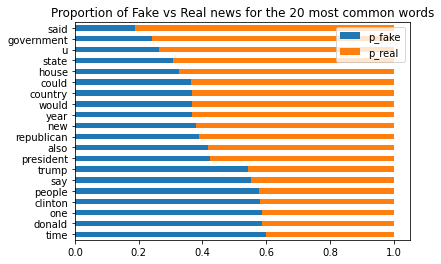

In [13]:
(word_counts
 .assign(p_fake=word_counts.fake / word_counts['all'],
         p_real=word_counts.real / word_counts['all'])
 .sort_values(by='all')
 [['p_fake', 'p_real']]
 .tail(20)
 .sort_values('p_real')
 .plot.barh(stacked=True))

plt.title('Proportion of Fake vs Real news for the 20 most common words')
plt.show()

# Takeaways
* We found that time, one, donald, people, and clinton were the words that appeared in greater proportion in fake news stories.

In [14]:
word_counts_all = (word_counts
 [(word_counts.fake > 10) & (word_counts['all'] > 10)]
 .assign(ratio=lambda df: df.fake / (df['all'] + .01))
 .sort_values(by='all', ascending = False)
 .pipe(lambda df: pd.concat([df.head(), df.head(20)])))

In [15]:
word_counts_all

,all,fake,real,ratio
said,120723,22915,97808,0.189815
trump,117346,63612,53734,0.542089
u,55236,14595,40641,0.264230
state,51837,15895,35942,0.306634
would,49318,18163,31155,0.368283
said,120723,22915,97808,0.189815
trump,117346,63612,53734,0.542089
u,55236,14595,40641,0.264230
state,51837,15895,35942,0.306634
would,49318,18163,31155,0.368283


* 50 percent of all had trump as a keyword, 54 percent of these instances are fake.
* The higest amkount of instances is associated with the word said at 118359 instances.
* The word said only occured in 19% of fake articles, while 81% where associated with real news articles.
* The second highest ammount of intances is associated with the word/name trump at 115797 intances and making up over 53% being in fake news realted articles. 

In [16]:
word_counts_fake = (word_counts
 [(word_counts.fake > 10) & (word_counts.real > 10)]
 .assign(ratio=lambda df: df.fake / (df.real + .01))
 .sort_values(by='ratio', ascending = False)
 .pipe(lambda df: pd.concat([df.head(), df.head(20)])))

In [17]:
word_counts_fake

,all,fake,real,ratio
cop,956,940,16,58.713304
hannity,955,939,16,58.650843
gop,3787,3696,91,40.610922
damn,440,428,12,35.636969
rant,472,459,13,35.280553
cop,956,940,16,58.713304
hannity,955,939,16,58.650843
gop,3787,3696,91,40.610922
damn,440,428,12,35.636969
rant,472,459,13,35.280553


* Fake news articles tend to have words with negative connotations such as bigoted, disgusting, pathetic, insane, and idiot. 

In [18]:
word_counts_real = (word_counts
 [(word_counts.fake > 10) & (word_counts.real > 10)]
 .assign(ratio=lambda df: df.real / (df.fake + .01))
 .sort_values(by='ratio', ascending = False)
 .pipe(lambda df: df.head(20)))

In [19]:
word_counts_real

,all,fake,real,ratio
thats,1166,17,1149,67.548501
im,1229,18,1211,67.240422
lebanese,671,11,660,59.945504
dont,2044,38,2006,52.775585
parliamentary,804,15,789,52.564957
km,704,14,690,49.250535
ankara,892,18,874,48.528595
beijing,2128,44,2084,47.352874
beirut,524,11,513,46.594005
hong,562,12,550,45.795171


* Real news articles use words that are more centered around world events and places.
* Ankara is the captiol of turkey
* sdf may be syarian democratic forces, a type of geospacial file type, or self defense force

## Wordclouds for Real-Fake-Combined


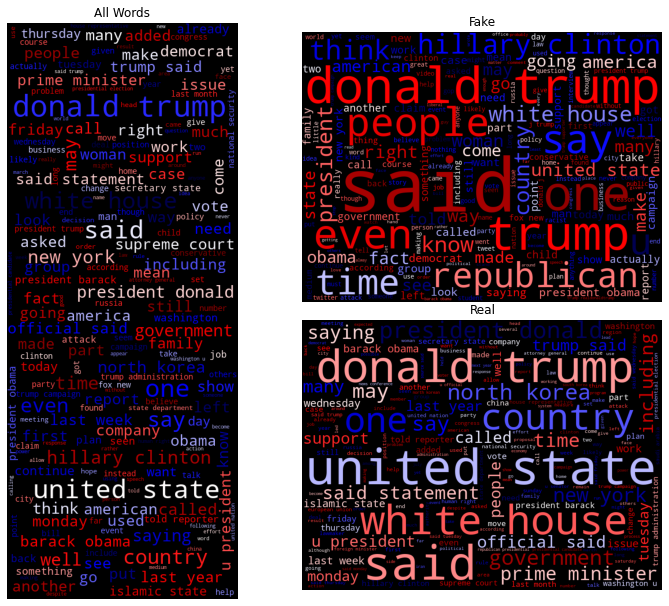

In [20]:
all_cloud = WordCloud(background_color='black', height=1000, width=400, colormap="seismic_r").generate(' '.join(all_words))
fake_cloud = WordCloud(background_color='black', height=600, width=800, colormap="seismic_r").generate(' '.join(fake_words))
real_cloud = WordCloud(background_color='black', height=600, width=800, colormap="seismic_r").generate(' '.join(real_words))

plt.figure(figsize=(10, 8))
axs = [plt.axes([0, 0, .5, 1]), plt.axes([.5, .5, .5, .5]), plt.axes([.5, 0, .5, .5])]

axs[0].imshow(all_cloud)
axs[1].imshow(fake_cloud)
axs[2].imshow(real_cloud)

axs[0].set_title('All Words')
axs[1].set_title('Fake')
axs[2].set_title('Real')

for ax in axs: ax.axis('off')

## Takeaways
* Said and donald trump are the top two words in the fake news related articles. 
* This could be related to some quates that were infered by the press or misleading. (I'd like to look into this deeper and actualy compare if these statments match what trump acutaly said)

## Bigrams (Fake - Real)

In [21]:
top_20_fake_bigrams = (pd.Series(nltk.ngrams(fake_words, 2))
                      .value_counts()
                      .head(20))

top_20_fake_bigrams.head()

(donald, trump)       11299
(hillary, clinton)     5002
(white, house)         4832
(united, state)        4601
(president, obama)     3215
dtype: int64

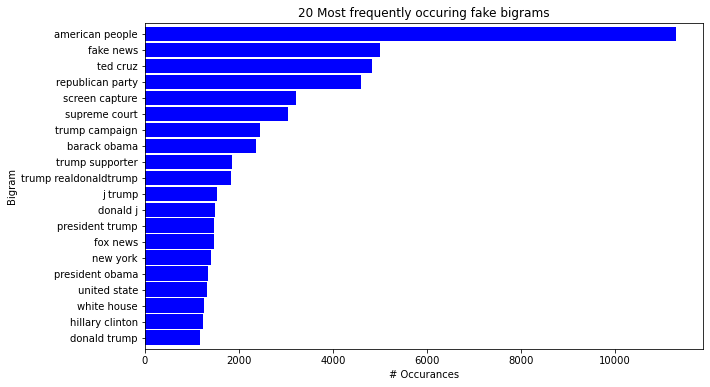

In [22]:
top_20_fake_bigrams.sort_values().plot.barh(color='blue', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring fake bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

ticks, _ = plt.yticks()
labels = top_20_fake_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

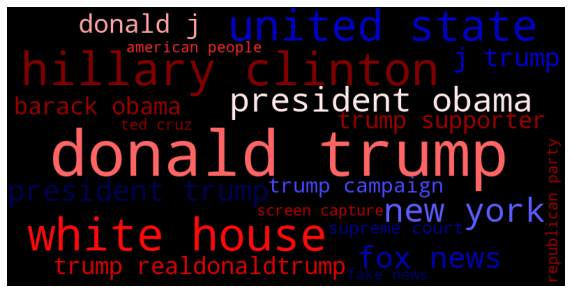

In [23]:
data = {k[0] + ' ' + k[1] : v for k, v in top_20_fake_bigrams.to_dict().items()}
img = WordCloud(random_state=1414, background_color='black', width=800, height=400, colormap="seismic_r").generate_from_frequencies(data)
plt.figure(figsize=(10, 8))
plt.imshow(img)
plt.axis('off')
plt.show()

# Takeaways 
* The bigrams for fake news articles are filled with "in house" events and places such as supreme count, republican part, and trumps twitter tag. 

In [24]:
top_20_real_bigrams = (pd.Series(nltk.ngrams(real_words, 2))
                      .value_counts()
                      .head(20))

top_20_real_bigrams.head()

(united, state)        12014
(donald, trump)        10051
(white, house)          8304
(president, donald)     5866
(north, korea)          5482
dtype: int64

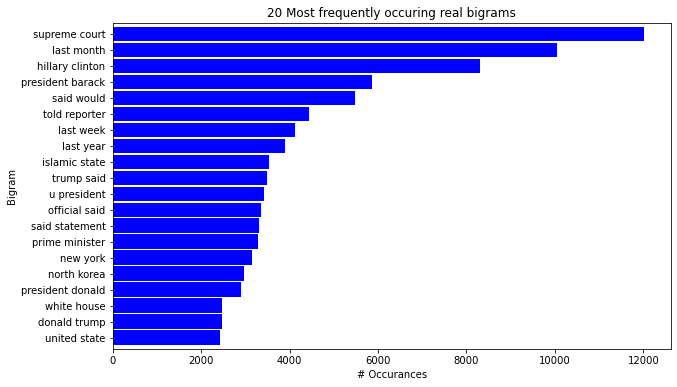

In [25]:
top_20_real_bigrams.sort_values().plot.barh(color='blue', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring real bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_real_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

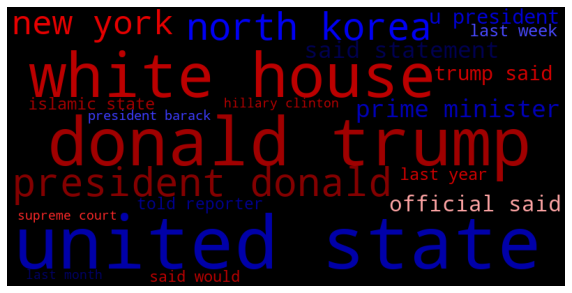

In [26]:
data = {k[0] + ' ' + k[1] : v for k, v in top_20_real_bigrams.to_dict().items()}
img = WordCloud(random_state=1414, background_color='black', width=800, height=400, colormap="seismic_r").generate_from_frequencies(data)
plt.figure(figsize=(10, 8))
plt.imshow(img)
plt.axis('off')
plt.show()

# Takeaways 
* The bigrams for real news are filled with phrases that represent world events and significant moments in time.

## Trigrams (Real - Fake)

In [27]:
top_20_real_trigrams2 = (pd.Series(nltk.ngrams(real_words, 3))
                      .value_counts()
                      .head(20))

top_20_real_trigrams2.head()

(president, donald, trump)     5796
(u, president, donald)         2493
(president, barack, obama)     1992
(white, house, said)            953
(president, barack, obamas)     900
dtype: int64

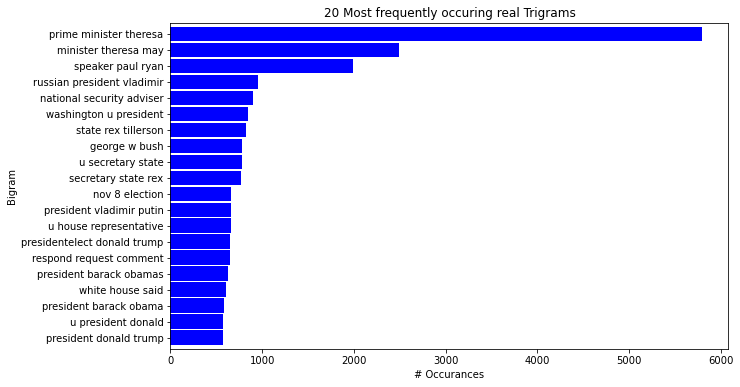

In [28]:
top_20_real_trigrams2.sort_values().plot.barh(color='blue', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring real Trigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_real_trigrams2.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1] + ' ' + t[2])
_ = plt.yticks(ticks, labels)

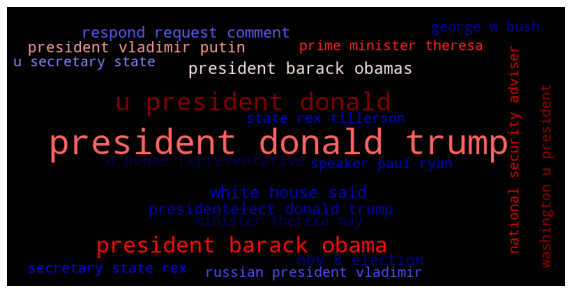

In [29]:
data = {k[0] + ' ' + k[1] + ' ' + k[2]: v for k, v in top_20_real_trigrams2.to_dict().items()}
img = WordCloud(random_state=1414, background_color='black', colormap="seismic_r", width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(10, 8))
plt.imshow(img)
plt.axis('off')
plt.show()

In [30]:
top_20_fake_trigrams2 = (pd.Series(nltk.ngrams(fake_words, 3))
                      .value_counts()
                      .head(20))

top_20_fake_trigrams2.head()

(donald, j, trump)             1818
(j, trump, realdonaldtrump)    1524
(new, york, time)              1068
(21st, century, wire)           954
(black, life, matter)           785
dtype: int64

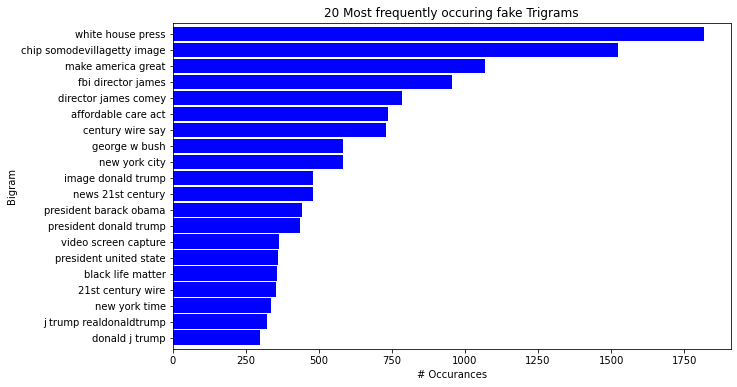

In [31]:
top_20_fake_trigrams2.sort_values().plot.barh(color='blue', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring fake Trigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_fake_trigrams2.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1] + ' ' + t[2])
_ = plt.yticks(ticks, labels)

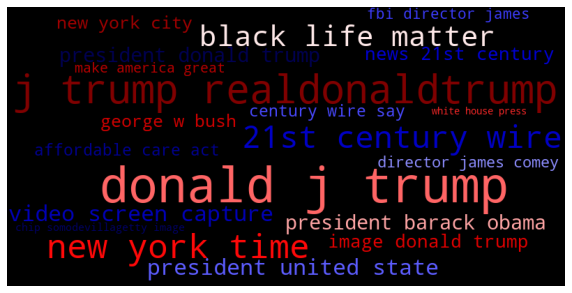

In [32]:
data = {k[0] + ' ' + k[1] + ' ' + k[2]: v for k, v in top_20_fake_trigrams2.to_dict().items()}
img = WordCloud(random_state=1414, background_color='black', colormap="seismic_r", width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(10, 8))
plt.imshow(img)
plt.axis('off')
plt.show()

In [33]:
#over 51% of articles contain word trump
articles_df[articles_df.clean_text.str.contains('trump')].shape[0] / articles_df.shape[0]

0.5129492121807974

In [34]:
#of all articles contraining the word trump 52% are considered fake news
trump = articles_df[articles_df.clean_text.str.contains('trump')]
trump.is_fake.value_counts(normalize=True)

True     0.517603
False    0.482397
Name: is_fake, dtype: float64

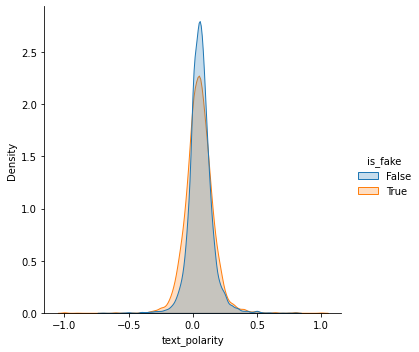

In [35]:
sns.displot(trump, x="text_polarity", hue="is_fake", kind="kde", fill=True, palette='tab10')

In [36]:
trump[trump.is_fake == True].text_polarity.mean(), trump[trump.is_fake == False].text_polarity.mean()

(0.04711589188871819, 0.05601583608270497)

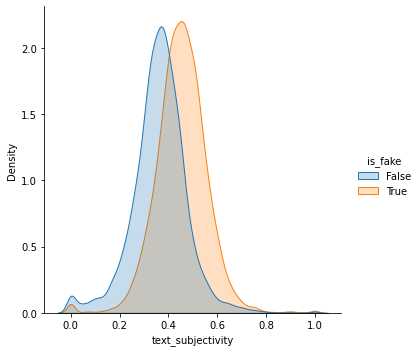

In [37]:
sns.displot(trump, x="text_subjectivity", hue="is_fake", kind="kde", fill=True, palette='tab10')

In [38]:
trump[trump.is_fake == True].text_subjectivity.mean(), trump[trump.is_fake == False].text_subjectivity.mean()

(0.4516646988927823, 0.3619910260325829)

In [39]:
trump_fake_news = trump[trump.is_fake == True]

trump_fake_words = ' '.join(trump_fake_news.clean_text)

trump_fake_freq = pd.Series(trump_fake_words.split()).value_counts()
trump_fake_freq.head(20)

trump         63612
president     14963
donald        14734
said          14030
people        12684
would         11530
one           11248
republican    10267
like           9643
u              8841
time           8489
state          8437
clinton        8377
say            7715
american       7644
even           7532
obama          7489
white          7184
campaign       7100
also           6868
dtype: int64

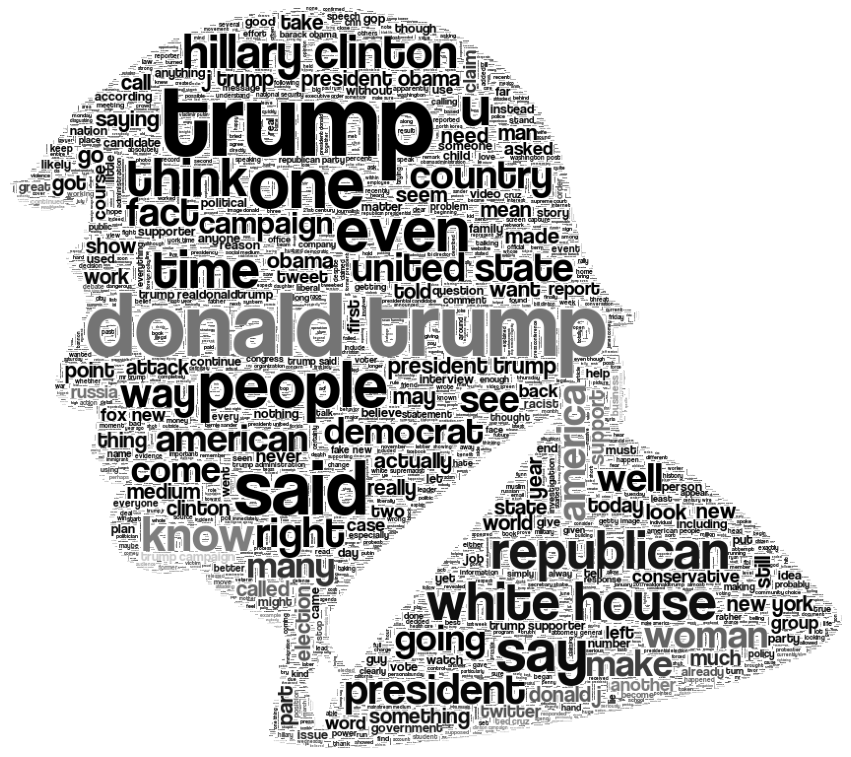

In [40]:
#masked python word cloud
font_path = 'Photos/coolvetica rg.ttf'
mask = np.array(Image.open('Photos/trump2.png'))
mask_colors = ImageColorGenerator(mask)
trump_fake_cloud = WordCloud(mask=mask,
                         width=mask.shape[1],
                         height=mask.shape[0],
                         max_words=None,
                         min_font_size=1,
                         font_path=font_path,
                         background_color=None,
                         mode='RGBA',
                         color_func=mask_colors,
                         random_state=45                         
                         ).generate(trump_fake_words)
plt.figure(figsize=(15, 15))
plt.axis('off')
plt.imshow(trump_fake_cloud)

## Sentiment Analysis

array([[<AxesSubplot:title={'center':'title_polarity'}>,
        <AxesSubplot:title={'center':'title_subjectivity'}>],
       [<AxesSubplot:title={'center':'text_polarity'}>,
        <AxesSubplot:title={'center':'text_subjectivity'}>]], dtype=object)

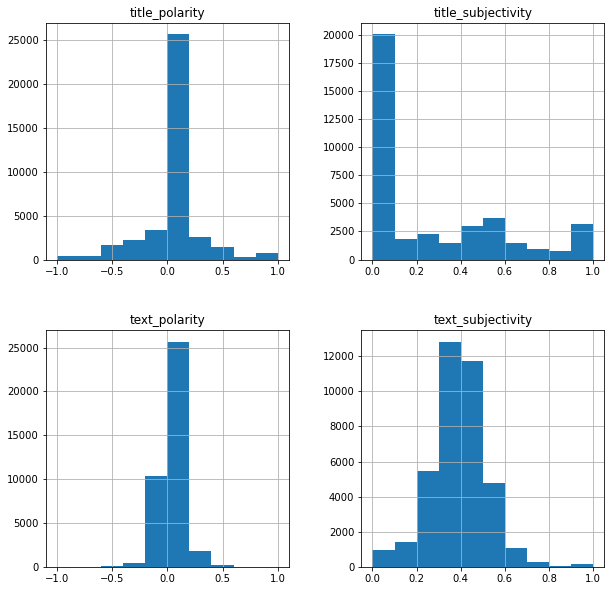

In [41]:
articles_df[['title_polarity','title_subjectivity','text_polarity','text_subjectivity']].hist(figsize=[10,10])

<AxesSubplot:xlabel='is_fake', ylabel='Count'>

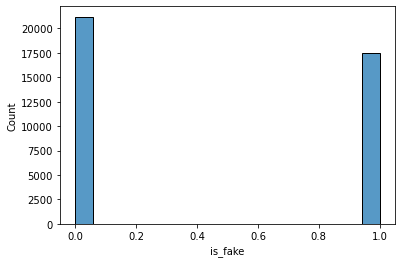

In [42]:
sns.histplot(articles_df.is_fake)

In [43]:
articles_df.describe()

,title_polarity,title_subjectivity,text_polarity,text_subjectivity
count,38651.000000,38651.000000,38651.000000,38651.000000
mean,0.010275,0.259378,0.044616,0.388708
std,0.258781,0.325281,0.107849,0.128831
min,-1.000000,0.000000,-1.000000,0.000000
25%,0.000000,0.000000,-0.009058,0.318308
50%,0.000000,0.050000,0.041856,0.390278
75%,0.000000,0.500000,0.097148,0.462888
max,1.000000,1.000000,1.000000,1.000000


## Distribution Takeaways
- titles overall don't seem to be polarized or subjective
- text polarity and subjectivity look normally distributed. Can perform T-tests
- fake articles are 46% of the dataset

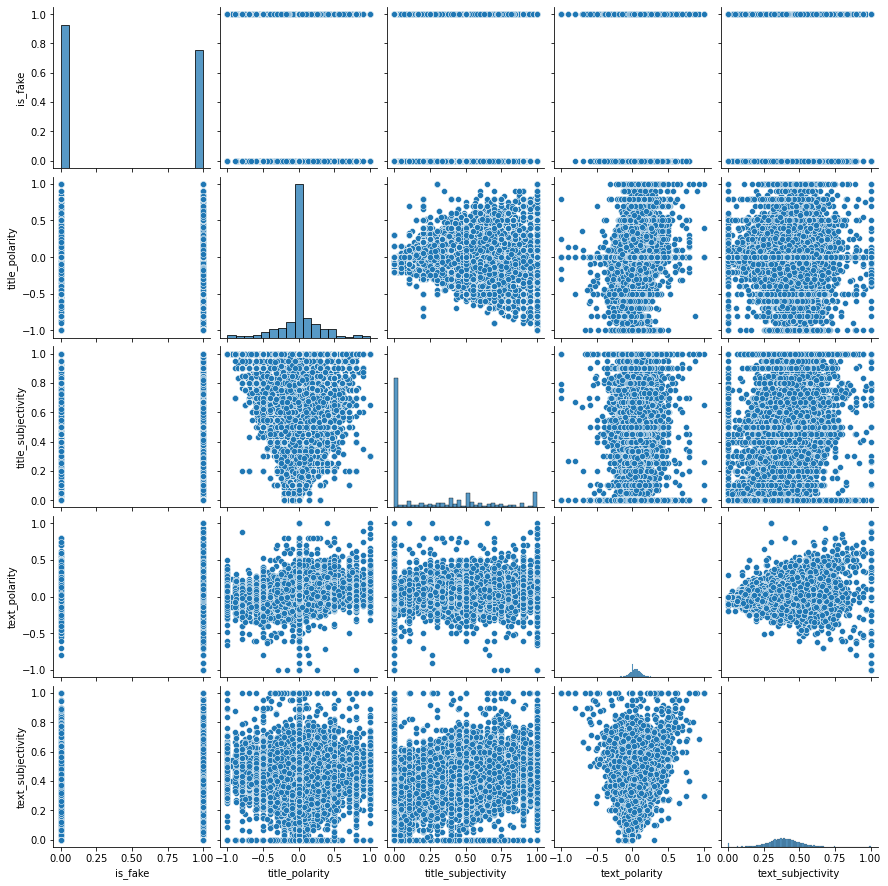

In [44]:
sns.pairplot(articles_df)

In [ ]:
sns.swarmplot(x='is_fake', y='text_polarity',data=articles_df)

In [ ]:
sns.swarmplot(x='is_fake', y='text_subjectivity',data=articles_df)

## Hypothesis Testing

In [45]:
confidence_level = .95
a = 1 - confidence_level

In [46]:
real_news = articles_df[articles_df.is_fake == False]
fake_news = articles_df[articles_df.is_fake == True]

### 1. Is the mean text polarity of fake news articles more negative than real news?

In [47]:
null_hypothesis = "The mean text polarity of fake news is the not more negative than real news"
alternative_hypothesis = "The mean text polarity of fake news is more negative than real news"

In [48]:
t, p = stats.ttest_ind(fake_news.text_polarity, real_news.text_polarity)

utils.evaluate_hypothesis_ttest(p, t, a, tails="less", null_hypothesis=null_hypothesis, alternative_hypothesis=alternative_hypothesis)

------------------------------------------
t:  3.3206511665242555, p:  0.0008989084937818361, a:  0.050000000000000044

We fail to reject the null hypothesis:  The mean text polarity of fake news is the not more negative than real news
------------------------------------------


{'t': 3.3206511665242555,
 'p': 0.0008989084937818361,
 'a': 0.050000000000000044,
 'message': 'We fail to reject the null hypothesis:  The mean text polarity of fake news is the not more negative than real news',
 'reject_null': False}

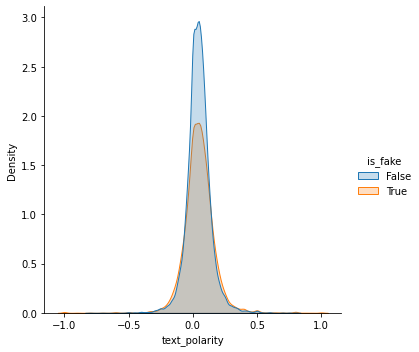

In [49]:
sns.displot(articles_df, x="text_polarity", hue="is_fake", kind="kde", fill=True)

In [50]:
fake_news.text_polarity.mean(), real_news.text_polarity.mean()

(0.04662353291118229, 0.042963581460989234)

No significant difference between mean polarities

### 2. Is the mean text subjectivity of fake news articles greater than real news?

In [51]:
null_hypothesis = "The mean text subjectivity of fake news is the not more subjective than real news"
alternative_hypothesis = "The mean text subjectivity of fake news is more subjective than real news"

In [52]:
t, p = stats.ttest_ind(fake_news.text_subjectivity, real_news.text_subjectivity)

utils.evaluate_hypothesis_ttest(p, t, a, tails="greater", null_hypothesis=null_hypothesis, alternative_hypothesis=alternative_hypothesis)

------------------------------------------
t:  74.08236108883078, p:  0.0, a:  0.050000000000000044

We reject the null hypothesis. We move forward with the alternative hypothesis:  The mean text subjectivity of fake news is more subjective than real news
------------------------------------------


{'t': 74.08236108883078,
 'p': 0.0,
 'a': 0.050000000000000044,
 'message': 'We reject the null hypothesis. We move forward with the alternative hypothesis:  The mean text subjectivity of fake news is more subjective than real news',
 'reject_null': True}

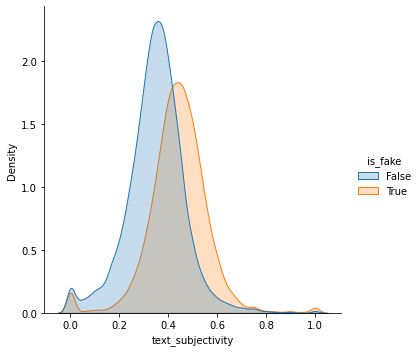

In [53]:
sns.displot(articles_df, x="text_subjectivity", hue="is_fake", kind="kde", fill=True, palette='tab10')

In [54]:
fake_news.text_subjectivity.mean(), real_news.text_subjectivity.mean()

(0.43876877482594273, 0.34748319551782963)

fake_news 22% higher mean subjectivity score

In [138]:
word_freq_df = utils.generate_tf_idf_tfidf_dataframe(pd.Series(all_words), articles_df.clean_text)

In [142]:
word_freq_df.sort_values(by='frequency', ascending=False).head(10)

,word,raw_count,frequency,augmented_frequency,idf,tf_idf
0,said,120723,0.013473,1.000000,0.261777,0.003527
1,trump,117346,0.013096,0.972027,0.667578,0.008742
2,u,55465,0.006190,0.459440,0.003213,0.000020
3,state,51837,0.005785,0.429388,0.504490,0.002918
4,would,49318,0.005504,0.408522,0.637813,0.003510
5,president,46265,0.005163,0.383233,0.491675,0.002539
6,republican,36001,0.004018,0.298212,1.128364,0.004533
7,people,35863,0.004002,0.297068,0.825249,0.003303
8,one,31120,0.003473,0.257780,0.355334,0.001234
9,year,29363,0.003277,0.243226,0.799080,0.002619


In [143]:
word_freq_df.sort_values(by='idf', ascending=False).head(10)

,word,raw_count,frequency,augmented_frequency,idf,tf_idf
109190,dnchow,1,1.116001e-07,0.000008,10.562328,0.000001
141575,201651,1,1.116001e-07,0.000008,10.562328,0.000001
141564,nansen,1,1.116001e-07,0.000008,10.562328,0.000001
141565,become1,1,1.116001e-07,0.000008,10.562328,0.000001
141566,angleas,1,1.116001e-07,0.000008,10.562328,0.000001
141567,2013three,1,1.116001e-07,0.000008,10.562328,0.000001
141569,ironici,1,1.116001e-07,0.000008,10.562328,0.000001
141570,timetaylor,1,1.116001e-07,0.000008,10.562328,0.000001
141571,pictwittercomvokak70rem,1,1.116001e-07,0.000008,10.562328,0.000001
141572,thatexcept,1,1.116001e-07,0.000008,10.562328,0.000001


In [144]:
word_freq_df.sort_values(by='tf_idf', ascending=False).head(10)

,word,raw_count,frequency,augmented_frequency,idf,tf_idf
1,trump,117346,0.013096,0.972027,0.667578,0.008742
15,clinton,22522,0.002513,0.186559,1.831315,0.004603
6,republican,36001,0.004018,0.298212,1.128364,0.004533
0,said,120723,0.013473,1.000000,0.261777,0.003527
4,would,49318,0.005504,0.408522,0.637813,0.003510
21,party,20897,0.002332,0.173099,1.474946,0.003440
12,government,25300,0.002823,0.209571,1.177110,0.003324
7,people,35863,0.004002,0.297068,0.825249,0.003303
25,obama,19677,0.002196,0.162993,1.464932,0.003217
14,house,24873,0.002776,0.206034,1.149863,0.003192


## Clustering

In [57]:
train_validate, test = train_test_split(articles_df, stratify=articles_df.is_fake, test_size=.2, random_state=1414)
train, validate = train_test_split(train_validate, stratify=train_validate.is_fake, test_size=.3, random_state=1414)

<AxesSubplot:xlabel='text_subjectivity', ylabel='text_polarity'>

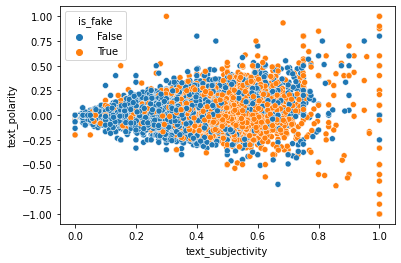

In [4]:
sns.scatterplot(y=train.text_polarity, x=train.text_subjectivity, hue='is_fake', data=train)

The higher the text_subjectivity, the more polarized the text is in both directions. Also, fake news articles seem to have a text_subjectivity score of .4 or higher which is supported by statistical testing.

<AxesSubplot:xlabel='title_subjectivity', ylabel='title_polarity'>

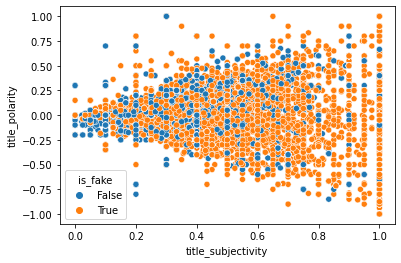

In [5]:
sns.scatterplot(x=train.title_subjectivity, y=train.title_polarity, hue='is_fake', data=train)

The title subjectivity and polarity did not show much distinction between real and fake news articles. The only visible trend is that as titles became more subjective, the polarity score went further away from zero.

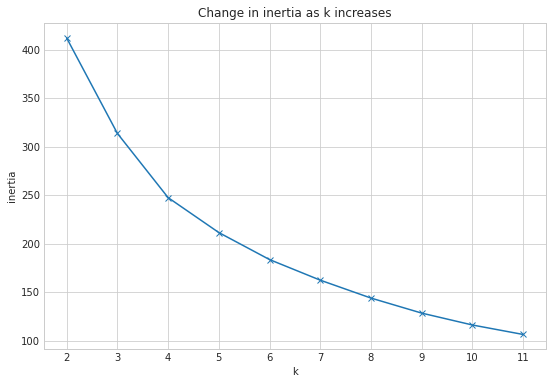

In [58]:
X_train, X_validate, X_test = utils.generate_elbow_plot(train, validate, test, \
                                                        ['text_subjectivity', 'text_polarity'])

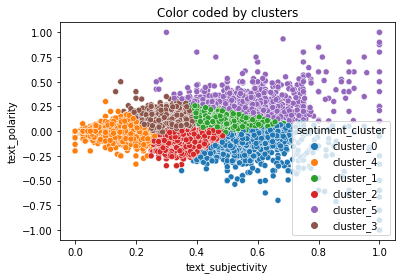

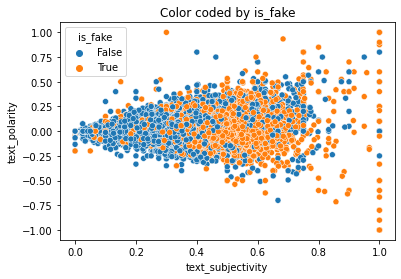

In [59]:
utils.fit_clusters(train, validate, test, X_train, X_validate, X_test, 6,\
                   'sentiment_cluster', y_plot='text_polarity', x_plot='text_subjectivity', compare_hue='is_fake')

In [60]:
cluster_0 = train[train.sentiment_cluster == "cluster_0"]
cluster_1 = train[train.sentiment_cluster == "cluster_1"]
cluster_2 = train[train.sentiment_cluster == "cluster_2"]
cluster_3 = train[train.sentiment_cluster == "cluster_3"]
cluster_4 = train[train.sentiment_cluster == "cluster_4"]
cluster_5 = train[train.sentiment_cluster == "cluster_5"]

In [116]:
cluster_0.is_fake.value_counts()

True     1211
False     361
Name: is_fake, dtype: int64

In [117]:
cluster_0.describe()

,title_polarity,title_subjectivity,text_polarity,text_subjectivity
count,1572.000000,1572.000000,1572.000000,1572.000000
mean,-0.089711,0.405210,-0.112624,0.571913
std,0.347539,0.375741,0.132187,0.103031
min,-1.000000,0.000000,-1.000000,0.350000
25%,-0.250000,0.000000,-0.149916,0.509021
50%,0.000000,0.400000,-0.079450,0.549714
75%,0.000000,0.725000,-0.033422,0.601769
max,1.000000,1.000000,0.088258,1.000000


`cluster_0` articles have high negative mean and median values for text_polarity and high text_subjectivity on average. These are "negative_bias_non_factual" articles.

In [118]:
cluster_1.is_fake.value_counts()

True     3665
False    2242
Name: is_fake, dtype: int64

In [119]:
cluster_1.describe()

,title_polarity,title_subjectivity,text_polarity,text_subjectivity
count,5907.000000,5907.000000,5907.000000,5907.000000
mean,0.037821,0.324450,0.094336,0.467725
std,0.289234,0.347703,0.053264,0.051536
min,-1.000000,0.000000,-0.018802,0.372917
25%,0.000000,0.000000,0.053427,0.427652
50%,0.000000,0.250000,0.089937,0.459260
75%,0.133333,0.566667,0.131078,0.499148
max,1.000000,1.000000,0.266270,0.686012


`cluster_1` articles are mostly fake with close to zero text_polarity and high text_subjectivity on average. This cluster contains "unbiased_mostly_non_factual" articles.

In [122]:
cluster_2.is_fake.value_counts()

False    2627
True     2136
Name: is_fake, dtype: int64

In [123]:
cluster_2.describe()

,title_polarity,title_subjectivity,text_polarity,text_subjectivity
count,4763.000000,4763.000000,4.763000e+03,4763.000000
mean,-0.040573,0.249314,-3.640093e-02,0.379152
std,0.243366,0.314617,5.122696e-02,0.052140
min,-1.000000,0.000000,-3.500000e-01,0.250000
25%,-0.066667,0.000000,-5.937689e-02,0.342255
50%,0.000000,0.050000,-2.616808e-02,0.382625
75%,0.000000,0.466667,4.047688e-18,0.417112
max,1.000000,1.000000,4.152672e-02,0.495361


`cluster_2` articles have a negative mean and median text_polarity with moderate text_subjectivity on average. These articles are considered "negative_bias_mostly_factual".

In [124]:
cluster_3.is_fake.value_counts()

False    4440
True     1726
Name: is_fake, dtype: int64

In [125]:
cluster_3.describe()

,title_polarity,title_subjectivity,text_polarity,text_subjectivity
count,6166.000000,6166.000000,6166.000000,6166.000000
mean,0.033596,0.198677,0.074709,0.326805
std,0.204368,0.279062,0.049317,0.044213
min,-1.000000,0.000000,-0.018034,0.133333
25%,0.000000,0.000000,0.040996,0.295250
50%,0.000000,0.000000,0.066780,0.332095
75%,0.025000,0.400000,0.100000,0.363576
max,1.000000,1.000000,0.500000,0.403239


`cluster_3` articles have positive mean and median text_polarity values and a moderate text_subjectivity score on average. These are "positive_bias_mostly_factual" articles.

In [126]:
cluster_4.is_fake.value_counts()

False    1812
True      400
Name: is_fake, dtype: int64

In [127]:
cluster_4.describe()

,title_polarity,title_subjectivity,text_polarity,text_subjectivity
count,2212.000000,2212.000000,2212.000000,2212.000000
mean,-0.005416,0.126470,-0.009108,0.154243
std,0.167971,0.243499,0.054657,0.082989
min,-1.000000,0.000000,-0.333333,0.000000
25%,0.000000,0.000000,-0.034591,0.100000
50%,0.000000,0.000000,0.000000,0.179315
75%,0.000000,0.125000,0.018750,0.222222
max,1.000000,1.000000,0.300000,0.265568


`cluster_4` is mostly real news articles with close to zero text_polarity and low text_subjectivity on average. This cluster can be named "unbiased_factual".

In [128]:
cluster_5.is_fake.value_counts()

True     637
False    387
Name: is_fake, dtype: int64

In [129]:
cluster_5.describe()

,title_polarity,title_subjectivity,text_polarity,text_subjectivity
count,1024.000000,1024.000000,1024.000000,1024.000000
mean,0.125968,0.369974,0.294311,0.576805
std,0.333507,0.373548,0.130338,0.122689
min,-1.000000,0.000000,0.094583,0.266667
25%,0.000000,0.000000,0.216158,0.498762
50%,0.000000,0.333333,0.260516,0.560749
75%,0.287202,0.700000,0.333333,0.627143
max,1.000000,1.000000,1.000000,1.000000


`cluster_5` articles are mostly fake articles with a positive mean and median text_polarity with high text_subjectivity on average. These are "positive_bias_non_factual" articles.

In [61]:
cluster_dict = {'cluster_4' : 'unbiased_factual', 'cluster_1' : 'unbiased_mostly_non_factual', 'cluster_5' : 'positive_bias_non_factual', \
               'cluster_2' : 'negative_bias_mostly_factual', 'cluster_0' : 'negative_bias_non_factual', 'cluster_3' : 'positive_bias_mostly_factual'}

train = utils.rename_clusters(cluster_dict, train, 'sentiment_cluster')
validate = utils.rename_clusters(cluster_dict, validate, 'sentiment_cluster')
test = utils.rename_clusters(cluster_dict, test, 'sentiment_cluster')

### Use these subsets to further explore (wordclouds, TF, IDF, TFIDF, etc) the different clusters

In [81]:
unbiased_factual = train[train.sentiment_cluster == 'unbiased_factual']
unbiased_mostly_non_factual = train[train.sentiment_cluster == 'unbiased_mostly_non_factual']
positive_bias_non_factual = train[train.sentiment_cluster == 'positive_bias_non_factual']
negative_bias_mostly_factual = train[train.sentiment_cluster == 'negative_bias_mostly_factual']
negative_bias_non_factual = train[train.sentiment_cluster == 'negative_bias_non_factual']
positive_bias_mostly_factual = train[train.sentiment_cluster == 'positive_bias_mostly_factual']

# Modeling

In [9]:
tfidf = TfidfVectorizer()

X = tfidf.fit_transform(articles_df.clean_text)
y = articles_df.is_fake

In [11]:
X_train_validate, X_test, y_train_validate, y_test = train_test_split(X, y, stratify=y, test_size=.2, random_state=1414)

X_train, X_validate, y_train, y_validate = train_test_split(X_train_validate, y_train_validate, stratify=y_train_validate, test_size=.3, random_state=1414)

In [12]:
X_train.shape, X_validate.shape, X_test.shape

((21644, 218346), (9276, 218346), (7731, 218346))

In [13]:
y_train.shape, y_validate.shape, y_test.shape

((21644,), (9276,), (7731,))

In [14]:
train = pd.DataFrame(dict(actual=y_train))
validate = pd.DataFrame(dict(actual=y_validate))
test = pd.DataFrame(dict(actual=y_test))

## Establish baseline model

In [15]:
articles_df.is_fake.value_counts()

False    21196
True     17455
Name: is_fake, dtype: int64

In [16]:
train['baseline_predicted'] = False
validate['baseline_predicted'] = False
test['baseline_predicted'] = False

In [17]:
utils.print_model_evaluation(train, 'baseline_predicted')

Accuracy: 54.84%
---
Confusion Matrix
actual              False  True 
baseline_predicted              
False               11869   9775
---
              precision    recall  f1-score   support

       False       0.55      1.00      0.71     11869
        True       0.00      0.00      0.00      9775

    accuracy                           0.55     21644
   macro avg       0.27      0.50      0.35     21644
weighted avg       0.30      0.55      0.39     21644



Baseline accuracy of 55% using True as default prediction for is_fake

## Logistic Regression

In [18]:
lm = LogisticRegression().fit(X_train, y_train)

train['log_predicted'] = lm.predict(X_train)
validate['log_predicted'] = lm.predict(X_validate)

In [19]:
utils.print_model_evaluation(train, 'log_predicted')

Accuracy: 98.62%
---
Confusion Matrix
actual         False  True 
log_predicted              
False          11760    190
True             109   9585
---
              precision    recall  f1-score   support

       False       0.98      0.99      0.99     11869
        True       0.99      0.98      0.98      9775

    accuracy                           0.99     21644
   macro avg       0.99      0.99      0.99     21644
weighted avg       0.99      0.99      0.99     21644



In [20]:
utils.print_model_evaluation(validate, 'log_predicted')

Accuracy: 97.68%
---
Confusion Matrix
actual         False  True 
log_predicted              
False           5007    135
True              80   4054
---
              precision    recall  f1-score   support

       False       0.97      0.98      0.98      5087
        True       0.98      0.97      0.97      4189

    accuracy                           0.98      9276
   macro avg       0.98      0.98      0.98      9276
weighted avg       0.98      0.98      0.98      9276



## Decision Tree

In [21]:
dcn_tree = DecisionTreeClassifier(max_depth=7, random_state=1414)
dcn_tree = dcn_tree.fit(X_train, y_train)

train['dcn_tree_predicted'] = dcn_tree.predict(X_train)
validate['dcn_tree_predicted'] = dcn_tree.predict(X_validate)

In [22]:
utils.print_model_evaluation(train, 'dcn_tree_predicted')

Accuracy: 90.34%
---
Confusion Matrix
actual              False  True 
dcn_tree_predicted              
False               10999   1221
True                  870   8554
---
              precision    recall  f1-score   support

       False       0.90      0.93      0.91     11869
        True       0.91      0.88      0.89      9775

    accuracy                           0.90     21644
   macro avg       0.90      0.90      0.90     21644
weighted avg       0.90      0.90      0.90     21644



In [23]:
utils.print_model_evaluation(validate, 'dcn_tree_predicted')

Accuracy: 88.45%
---
Confusion Matrix
actual              False  True 
dcn_tree_predicted              
False                4579    563
True                  508   3626
---
              precision    recall  f1-score   support

       False       0.89      0.90      0.90      5087
        True       0.88      0.87      0.87      4189

    accuracy                           0.88      9276
   macro avg       0.88      0.88      0.88      9276
weighted avg       0.88      0.88      0.88      9276



## Random Forest

In [24]:
rand_forest = RandomForestClassifier(bootstrap=True, class_weight="balanced", criterion='gini', min_samples_leaf=3, \
                                     n_estimators=100, max_depth=15, random_state=1414)
rand_forest = rand_forest.fit(X_train, y_train)

train['rand_forest_predicted'] = rand_forest.predict(X_train)
validate['rand_forest_predicted'] = rand_forest.predict(X_validate)

In [25]:
utils.print_model_evaluation(train, 'rand_forest_predicted')

Accuracy: 95.93%
---
Confusion Matrix
actual                 False  True 
rand_forest_predicted              
False                  11622    634
True                     247   9141
---
              precision    recall  f1-score   support

       False       0.95      0.98      0.96     11869
        True       0.97      0.94      0.95      9775

    accuracy                           0.96     21644
   macro avg       0.96      0.96      0.96     21644
weighted avg       0.96      0.96      0.96     21644



In [26]:
utils.print_model_evaluation(validate, 'rand_forest_predicted')

Accuracy: 94.61%
---
Confusion Matrix
actual                 False  True 
rand_forest_predicted              
False                   4926    339
True                     161   3850
---
              precision    recall  f1-score   support

       False       0.94      0.97      0.95      5087
        True       0.96      0.92      0.94      4189

    accuracy                           0.95      9276
   macro avg       0.95      0.94      0.95      9276
weighted avg       0.95      0.95      0.95      9276



## K Nearest Neighbors

In [27]:
knn = KNeighborsClassifier(n_neighbors=5, weights='uniform')
knn = knn.fit(X_train, y_train)

train['knn_predicted'] = knn.predict(X_train)
validate['knn_predicted'] = knn.predict(X_validate)

In [30]:
utils.print_model_evaluation(train, 'knn_predicted')

Accuracy: 87.94%
---
Confusion Matrix
actual         False  True 
knn_predicted              
False          11538   2279
True             331   7496
---
              precision    recall  f1-score   support

       False       0.84      0.97      0.90     11869
        True       0.96      0.77      0.85      9775

    accuracy                           0.88     21644
   macro avg       0.90      0.87      0.88     21644
weighted avg       0.89      0.88      0.88     21644



In [31]:
utils.print_model_evaluation(validate, 'knn_predicted')

Accuracy: 83.47%
---
Confusion Matrix
actual         False  True 
knn_predicted              
False           4862   1308
True             225   2881
---
              precision    recall  f1-score   support

       False       0.79      0.96      0.86      5087
        True       0.93      0.69      0.79      4189

    accuracy                           0.83      9276
   macro avg       0.86      0.82      0.83      9276
weighted avg       0.85      0.83      0.83      9276



## Naive Bayes - Bernoulli

In [51]:
nbb = BernoulliNB(alpha=0)
nbb = nbb.fit(X_train, y_train)

train['nbb_predicted'] = nbb.predict(X_train)
validate['nbb_predicted'] = nbb.predict(X_validate)

In [52]:
utils.print_model_evaluation(train, 'nbb_predicted')

Accuracy: 99.41%
---
Confusion Matrix
actual         False  True 
nbb_predicted              
False          11850    108
True              19   9667
---
              precision    recall  f1-score   support

       False       0.99      1.00      0.99     11869
        True       1.00      0.99      0.99      9775

    accuracy                           0.99     21644
   macro avg       0.99      0.99      0.99     21644
weighted avg       0.99      0.99      0.99     21644



In [53]:
utils.print_model_evaluation(validate, 'nbb_predicted')

Accuracy: 96.23%
---
Confusion Matrix
actual         False  True 
nbb_predicted              
False           4917    180
True             170   4009
---
              precision    recall  f1-score   support

       False       0.96      0.97      0.97      5087
        True       0.96      0.96      0.96      4189

    accuracy                           0.96      9276
   macro avg       0.96      0.96      0.96      9276
weighted avg       0.96      0.96      0.96      9276



## MVP

In [98]:
test['log_predicted'] = lm.predict(X_test)

In [99]:
utils.print_model_evaluation(test, 'log_predicted')

Accuracy: 97.57%
---
Confusion Matrix
actual         False  True 
log_predicted              
False           4177    125
True              63   3366
---
              precision    recall  f1-score   support

       False       0.97      0.99      0.98      4240
        True       0.98      0.96      0.97      3491

    accuracy                           0.98      7731
   macro avg       0.98      0.97      0.98      7731
weighted avg       0.98      0.98      0.98      7731

